In [2]:
import os
import time
import re 
import sys

#to supress warnings 
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.offline as pyo

#to read stocks from Yahoo
from pandas_datareader.data import DataReader
import yfinance as yf 
from pandas_datareader import data as pdr
from datetime import datetime 

# for data encoding
import category_encoders as ce

# for stationarity checks
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima.model import ARIMA

pd.options.plotting.backend = "plotly"
pyo.init_notebook_mode()
yf.pdr_override()

In [3]:
# Define the stock symbol and the time range
stock_symbols = ["AAPL", "MSFT", "GOOGL"]
#start_date = datetime.now() - pd.DateOffset(years=3)
#end_date = datetime.now()
start_date = datetime(2018, 1, 1)  # January 2018
end_date = datetime(2023, 1, 31)  # January 2023

# Fetch the stock data
stock_data = {}
for symbol in stock_symbols:
    stock_data[symbol] = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)

#Display the first few rows to check
stock_data["GOOGL"].head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-02  52.651001  53.799000  52.651001  53.660500  53.660500  31766000
2018-01-03  53.696499  54.805000  53.671501  54.576000  54.576000  31318000
2018-01-04  54.854500  55.203999  54.713001  54.787998  54.787998  26052000
2018-01-05  55.172501  55.679001  55.090000  55.514500  55.514500  30250000
2018-01-08  55.549999  55.958000  55.500000  55.710499  55.710499  24644000

In [4]:
#Convert to a panel dataset
final = []

for symbol in stock_symbols:
    tmp_df = pd.DataFrame()
    vals = stock_data[symbol]['Close'].tolist()

    tmp_df['Series'] = [symbol] * len(vals)
    tmp_df['Date'] = stock_data[symbol].index
    tmp_df['Values'] = vals
    final.append(tmp_df)

panel_data = pd.concat(final)
panel_data.set_index(['Series', 'Date'], inplace=True)

panel_data

Values
Series Date                 
AAPL   2018-01-02  43.064999
       2018-01-03  43.057499
       2018-01-04  43.257500
       2018-01-05  43.750000
       2018-01-08  43.587502
...                      ...
GOOGL  2023-01-24  97.699997
       2023-01-25  95.220001
       2023-01-26  97.519997
       2023-01-27  99.370003
       2023-01-30  96.940002

[3834 rows x 1 columns]

In [5]:
#Plotting: Overall Time Series first before preprocessing 
px.line(panel_data.reset_index(), 
        x = 'Date', 
        y = 'Values', 
        color = 'Series',
        title = 'Plot of Time Series')

In [6]:
#Check stationarity 
def check_stationarity(series):
    return adfuller(series, regression = 'c')[1]

In [7]:
# sort values first, then apply residual checks
results = panel_data.sort_values(by = ['Series', 'Date']).groupby(['Series'])['Values'].apply(check_stationarity)

# 100% of time series are not stationary
np.mean(results > .05)

1.0

In [8]:
#Preprocessing, differencing first
differences = panel_data.groupby(['Series'])['Values'].diff().reset_index().dropna()
results_diff = differences.groupby(['Series'])['Values'].apply(check_stationarity)
print("Proportion of non-stationary series after differencing:", np.mean(results_diff > .05))

# plot the differences
px.line(differences, x= 'Date', y = 'Values', color = 'Series')

Proportion of non-stationary series after differencing: 0.0


In [9]:
#Log transformation
log_returns = np.log1p(panel_data).groupby(['Series'])['Values'].diff().reset_index().dropna()
results_log = log_returns.groupby(['Series'])['Values'].apply(check_stationarity)
print("Proportion of non-stationary series after log returns:", np.mean(results_log > .05))

# plot the log differences
px.line(log_returns, x= 'Date', y = 'Values', color = 'Series')

Proportion of non-stationary series after log returns: 0.0


In [10]:
stock_data

{'AAPL':                   Open        High         Low       Close   Adj Close   
 Date                                                                     
 2018-01-02   42.540001   43.075001   42.314999   43.064999   40.776516  \
 2018-01-03   43.132500   43.637501   42.990002   43.057499   40.769421   
 2018-01-04   43.134998   43.367500   43.020000   43.257500   40.958794   
 2018-01-05   43.360001   43.842499   43.262501   43.750000   41.425129   
 2018-01-08   43.587502   43.902500   43.482498   43.587502   41.271271   
 ...                ...         ...         ...         ...         ...   
 2023-01-24  140.309998  143.160004  140.300003  142.529999  141.924500   
 2023-01-25  140.889999  142.429993  138.809998  141.860001  141.257339   
 2023-01-26  143.169998  144.250000  141.899994  143.960007  143.348419   
 2023-01-27  143.160004  147.229996  143.080002  145.929993  145.310043   
 2023-01-30  144.960007  145.550003  142.850006  143.000000  142.392487   
 
               

In [11]:
#Difference in log returns
final = []

for symbol in stock_symbols:
    print(f"Processing {symbol}...")

    vals = stock_data[symbol]['Close'].tolist()
    log_diffs = np.log(np.array(vals[1:]) / np.array(vals[:-1]))
    differences_log_diffs = log_diffs[1:] - log_diffs[:-1]
    
    tmp_df = pd.DataFrame()
    tmp_df['Series'] = [symbol] * len(differences_log_diffs)
    tmp_df['Date'] = stock_data[symbol].index[2:]  # Excluded the first two dates because log diff
    tmp_df['Values'] = differences_log_diffs
    final.append(tmp_df)

panel_data_log_diffs = pd.concat(final)
panel_data_log_diffs.set_index(['Series', 'Date'], inplace=True)

results_log_diffs = panel_data_log_diffs.groupby(['Series'])['Values'].apply(check_stationarity)
print("Proportion of non-stationary series after differencing log returns:", np.mean(results_log_diffs > .05))

panel_data_log_diffs_reset = panel_data_log_diffs.reset_index()
px.line(panel_data_log_diffs_reset, x= 'Date', y = 'Values', color = 'Series') 

Processing AAPL...
Processing MSFT...
Processing GOOGL...
Proportion of non-stationary series after differencing log returns: 0.0


In [12]:
panel_data_log_diffs

Values
Series Date                
AAPL   2018-01-04  0.004808
       2018-01-05  0.006687
       2018-01-08 -0.015042
       2018-01-09  0.003606
       2018-01-10 -0.000115
...                     ...
GOOGL  2023-01-24 -0.039063
       2023-01-25 -0.004545
       2023-01-26  0.049579
       2023-01-27 -0.005075
       2023-01-30 -0.043551

[3828 rows x 1 columns]

In [13]:
#Preprocessing
#Store dataframes after preprocessing
dfs_list = []

#Get each stock symbol
symbols = panel_data_log_diffs.index.get_level_values('Series').unique()
for symbol in symbols:
    #subset dataframe per stock
    subset = panel_data_log_diffs.loc[symbol]

    #convert index to datetime to set frequency and use ffill
    subset.index = pd.to_datetime(subset.index)
    subset = subset.asfreq('B').fillna(method='ffill')

    #convert index back to a period and append series column
    subset.index = subset.index.to_period('D')
    subset['Series'] = symbol
    subset.set_index('Series', append=True, inplace=True)
    subset = subset.swaplevel('Series', 'Date')

    dfs_list.append(subset)

# Concatenate the processed dataframes
panel_data_processed = pd.concat(dfs_list)


In [14]:
panel_data_processed

Values
Series Date                
AAPL   2018-01-04  0.004808
       2018-01-05  0.006687
       2018-01-08 -0.015042
       2018-01-09  0.003606
       2018-01-10 -0.000115
...                     ...
GOOGL  2023-01-24 -0.039063
       2023-01-25 -0.004545
       2023-01-26  0.049579
       2023-01-27 -0.005075
       2023-01-30 -0.043551

[3969 rows x 1 columns]

In [15]:
import pandas as pd
import numpy as np
from sktime.forecasting.arima import ARIMA

# Initialize an empty list to store DataFrames
results_dfs = []

for stock in ['AAPL', 'GOOGL', 'MSFT']:
    data = panel_data_processed.loc[stock]['Values'].dropna()
    
    # Loop over different window sizes
    for window_size in [3, 15, 30]:
        # Initialize an empty list to store ARIMA predictions for each fold
        arima_predictions = []
        
        # Perform cross-validation
        for i in range(len(data) - window_size):
            train_data = data.iloc[i:i+window_size]

            # Fit an ARIMA(1,1,0) model
            model = ARIMA(order=(1, 1, 0))
            model.fit(train_data)

            # Make one-step-ahead forecasts
            y_pred = model.predict(fh=np.array([1]))

            # Append the predictions to the list
            arima_predictions.append(y_pred[0])

        # Append stock results to the list of DataFrames
        results_dfs.append((stock, window_size, arima_predictions))

results_dfs

/Users/guhitj/opt/anaconda3/envs/time_series_ensembles/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/guhitj/opt/anaconda3/envs/time_series_ensembles/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/guhitj/opt/anaconda3/envs/time_series_ensembles/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/guhitj/opt/anaconda3/envs/time_series_ensembles/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/guhitj/opt/anaconda3/envs/time_series_ensembles/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization fail

[('AAPL',
  3,
  [-0.01367399682752835,
   -0.017589851168360628,
   0.01774748224896725,
   0.002967267053789889,
   0.010153193415551945,
   0.003961538031718676,
   -0.016209359112327043,
   0.0017125658871437535,
   0.021001503028876604,
   -0.041617918780875215,
   0.005193283334163434,
   0.010632453354251867,
   -0.004645830300734476,
   -0.026227672873796248,
   0.035913790696853465,
   -0.001326612277778954,
   -0.028146389344521756,
   0.046784766443586624,
   -0.0072769157726489155,
   -0.05605519802170866,
   -0.026539350773104195,
   0.13146046283110896,
   -0.01586961680448931,
   -0.13486362860819134,
   0.0919787428557357,
   0.07335313406924521,
   -0.034601270238554666,
   -0.05219401024999545,
   0.05148457290930818,
   -0.030308331451237146,
   -0.08703779646163465,
   0.0003428313152988622,
   0.03405905599065679,
   0.012322283576482096,
   0.022134630285948094,
   -0.0029297835595705098,
   -0.030839381119293345,
   -0.022694903472980976,
   0.00800964375190031,


In [22]:
# Create a DataFrame to store stock, window size, predictions, and y true values
results_df = pd.DataFrame(columns=['Stock', 'Window Size', 'Date', 'Original Price', 'ARIMA Prediction'])

# Populate the DataFrame with data from Block 1
for stock, window_size, arima_predictions in results_dfs:
    data = panel_data_processed.loc[stock]['Values'].dropna()
    window_size_predictions = arima_predictions
    date_index = data.index[-len(window_size_predictions):]
    original_prices = data.values[-len(window_size_predictions):]
    
    stock_results = pd.DataFrame({
        'Stock': [stock] * len(window_size_predictions),
        'Window Size': [window_size] * len(window_size_predictions),
        'Date': date_index,
        'Original Price': original_prices,
        'ARIMA Prediction': window_size_predictions
    })

    # Append stock results to the overall results DataFrame
    results_df = pd.concat([results_df, stock_results], ignore_index=True)

results_df

Stock Window Size        Date  Original Price  ARIMA Prediction
0      AAPL           3  2018-01-09        0.003606         -0.013674
1      AAPL           3  2018-01-10       -0.000115         -0.017590
2      AAPL           3  2018-01-11        0.005894          0.017747
3      AAPL           3  2018-01-12        0.004609          0.002967
4      AAPL           3  2018-01-15        0.004609          0.010153
...     ...         ...         ...             ...               ...
11758  MSFT          30  2023-01-24       -0.012005          0.010506
11759  MSFT          30  2023-01-25       -0.003697         -0.017358
11760  MSFT          30  2023-01-26        0.036177         -0.006531
11761  MSFT          30  2023-01-27       -0.029606          0.021152
11762  MSFT          30  2023-01-30       -0.022851         -0.001542

[11763 rows x 5 columns]

In [26]:
import pandas as pd
import numpy as np

# Initialize a list to store ARIMA prediction dictionaries for different window sizes
arima_predictions_list = []

for stock in ['AAPL', 'GOOGL', 'MSFT']:
    stock_df = stock_data[stock]
    stock_df.index = pd.to_datetime(stock_df.index)

    for window_size in [3, 15, 30]:
        stock_window_df = results_df[(results_df['Stock'] == stock) & (results_df['Window Size'] == window_size)]
        
        for index, row in stock_window_df.iterrows():
            date = row['Date'].to_timestamp()
            arima_prediction = row['ARIMA Prediction']

            if date in stock_df.index:
                original_price = stock_df.loc[date]['Close']
                arima_prediction_transformed = original_price * np.exp(arima_prediction)
                
                arima_predictions_list.append({
                    'Stock': stock,
                    'Date': date,
                    'Original Price': original_price,
                    'Window Size': window_size, 
                    'ARIMA Prediction Transformed': arima_prediction_transformed
                })

# Convert the list of dictionaries to DataFrame
final_arima_predictions_df = pd.DataFrame(arima_predictions_list)

# Pivot the DataFrame to have a column for each window size
final_arima_predictions_df = final_arima_predictions_df.pivot_table(index=['Stock', 'Date', 'Original Price'], 
                                                                    columns='Window Size', 
                                                                    values='ARIMA Prediction Transformed', 
                                                                    aggfunc='first').reset_index()

# Rename columns to include window size
final_arima_predictions_df.columns = [
    f'{col[0]} Window {col[1]}' if isinstance(col, tuple) else col
    for col in final_arima_predictions_df.columns
]

# Display the final DataFrame
final_arima_predictions_df


Stock       Date  Original Price           3          15          30
0     AAPL 2018-01-09       43.582500   42.990609         NaN         NaN
1     AAPL 2018-01-10       43.572498   42.812766         NaN         NaN
2     AAPL 2018-01-11       43.820000   44.604636         NaN         NaN
3     AAPL 2018-01-12       44.272499   44.404063         NaN         NaN
4     AAPL 2018-01-16       44.047501   44.222343         NaN         NaN
...    ...        ...             ...         ...         ...         ...
3814  MSFT 2023-01-24      242.039993  247.801498  246.210098  244.596359
3815  MSFT 2023-01-25      240.610001  220.189601  237.004174  236.469616
3816  MSFT 2023-01-26      248.000000  249.772683  245.318964  246.385709
3817  MSFT 2023-01-27      248.160004  259.648242  253.118541  253.464907
3818  MSFT 2023-01-30      242.710007  245.065207  243.725821  242.336057

[3819 rows x 6 columns]

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = []

def calculate_metrics(y_true, y_pred):
    # Remove NaN values
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        "MAPE": mape,
        "RMSE": rmse,
        "MAE": mae,
    }

stocks = final_arima_predictions_df['Stock'].unique()

for stock in stocks:
    stock_df = final_arima_predictions_df[final_arima_predictions_df['Stock'] == stock]
    
    y_true = stock_df['Original Price']

    for window_size in [3, 15, 30]:
        y_pred = stock_df[window_size]
        if y_pred.isna().all():  # Skip if all values are NaN
            continue

        metrics_values = calculate_metrics(y_true, y_pred)
        
        metrics.append({
            'Stock': stock,
            'Window Size': window_size,
            'MAPE': metrics_values['MAPE'],
            'RMSE': metrics_values['RMSE'],
            'MAE': metrics_values['MAE']
        })

# Create dataframe from metrics 
metrics_df = pd.DataFrame(metrics)

print(metrics_df)


   Stock  Window Size      MAPE       RMSE       MAE
0   AAPL            3  0.038151   5.643805  3.815753
1   AAPL           15  0.016256   2.392328  1.620785
2   AAPL           30  0.014396   2.141346  1.437496
3  GOOGL            3  0.036004   4.412201  3.086232
4  GOOGL           15  0.015332   1.924115  1.308198
5  GOOGL           30  0.013798   1.739474  1.182648
6   MSFT            3  0.035394  10.150349  6.883897
7   MSFT           15  0.015105   4.355420  2.933564
8   MSFT           30  0.013728   4.003382  2.685250


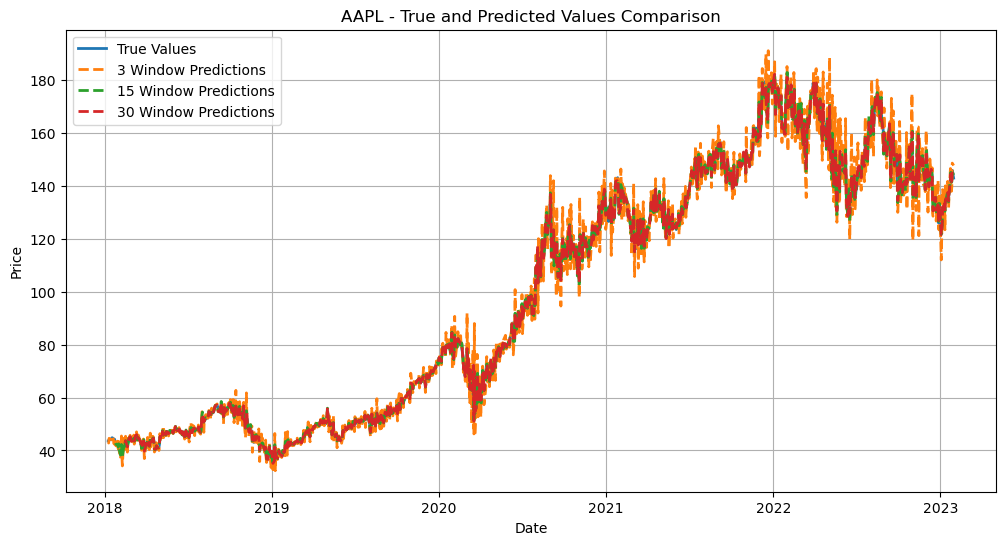

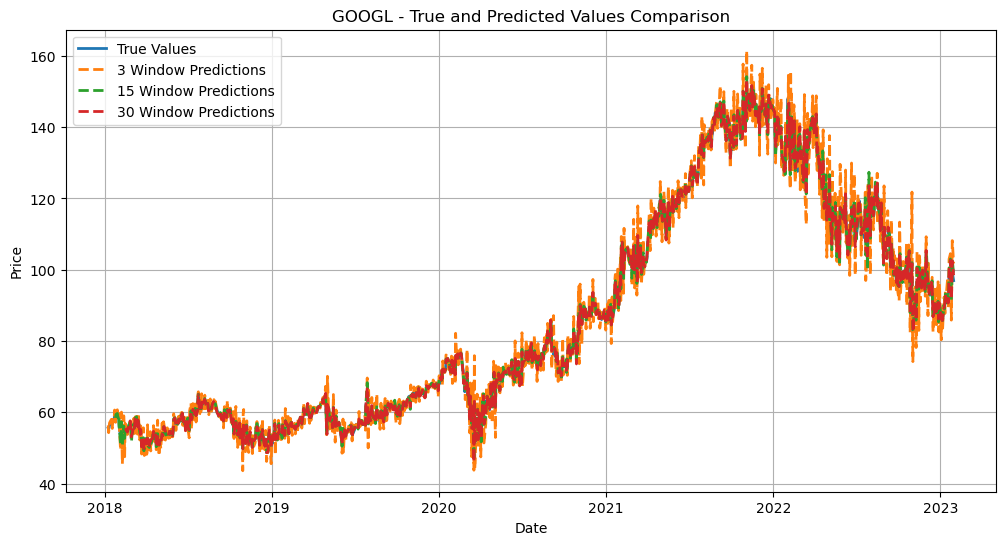

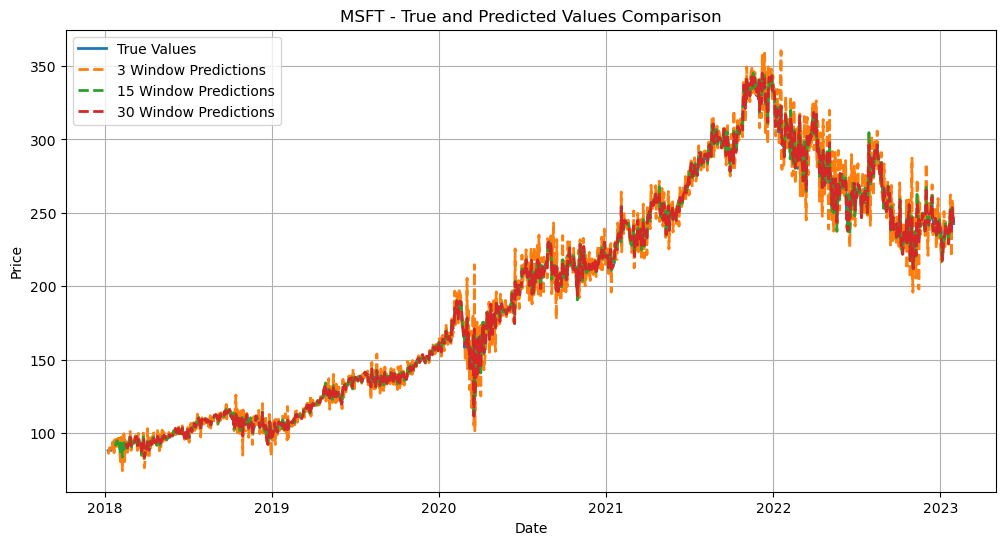

In [30]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

base_dir = '../results'
now = datetime.now()
date_time_str = now.strftime('%Y%m%d_%H%M%S')
new_dir = os.path.join(base_dir, f"arima_experimental_{date_time_str}")

if not os.path.exists(new_dir):
    os.makedirs(new_dir)

window_sizes = [3, 15, 30]
stocks = final_arima_predictions_df['Stock'].unique()

# Assuming metrics_df and final_arima_predictions_df have been calculated above.
final_arima_predictions_df.to_csv(os.path.join(new_dir, 'final_arima_predictions.txt'), sep='\t', index=False)
metrics_df.to_csv(os.path.join(new_dir, 'metrics.txt'), sep='\t', index=False)

for stock in stocks:
    # Filter final_arima_predictions_df for each stock
    filtered_df = final_arima_predictions_df[final_arima_predictions_df['Stock'] == stock]

    # Extract date and original price
    dates = filtered_df['Date']
    y_true = filtered_df['Original Price']

    # Initialize the plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Values', linewidth=2)

    # Plot predictions for each window_size
    for window_size in window_sizes:
        y_pred = filtered_df[window_size]
        plt.plot(dates, y_pred, label=f'{window_size} Window Predictions', linestyle='--', linewidth=2)

    # Customize and save the plot
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{stock} - True and Predicted Values Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(new_dir, f'{stock}_plot.png'))

plt.show()


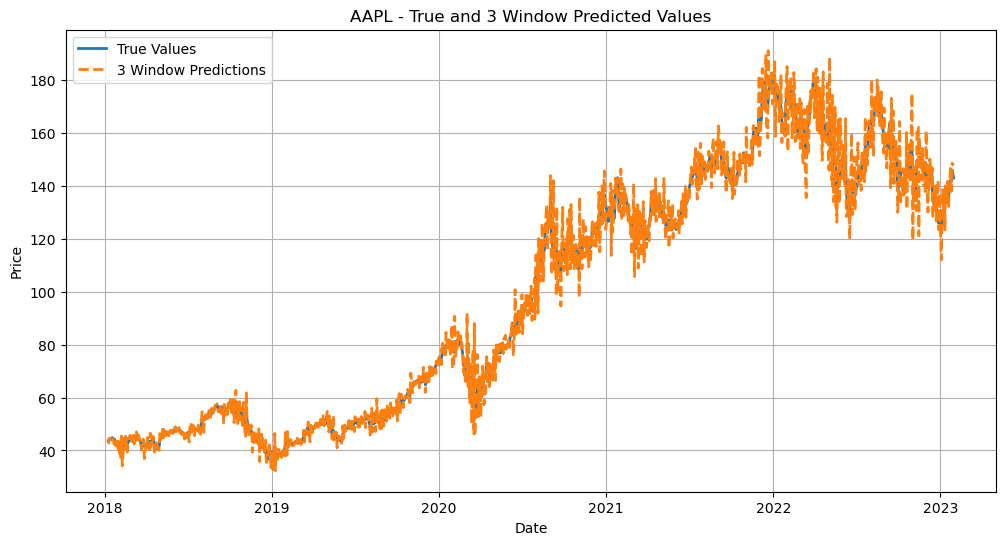

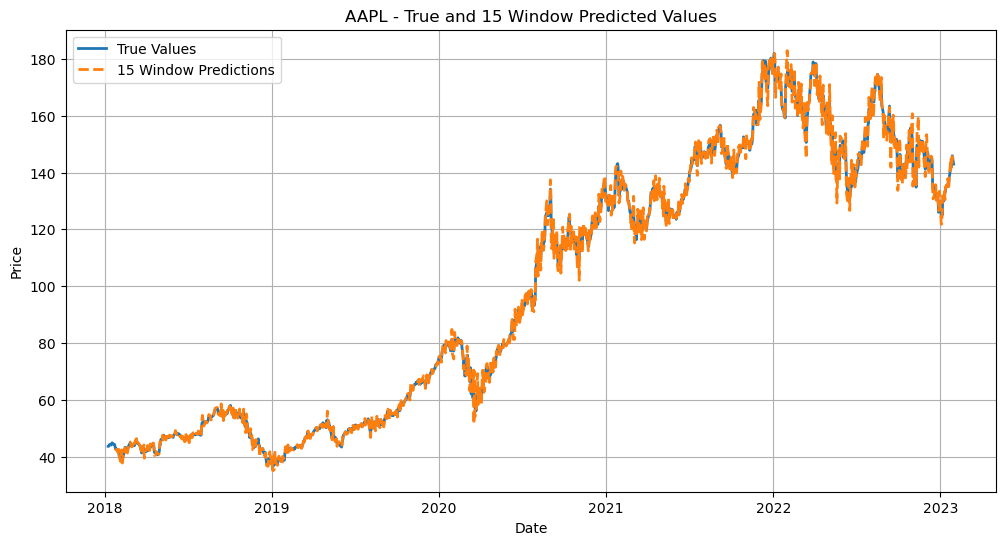

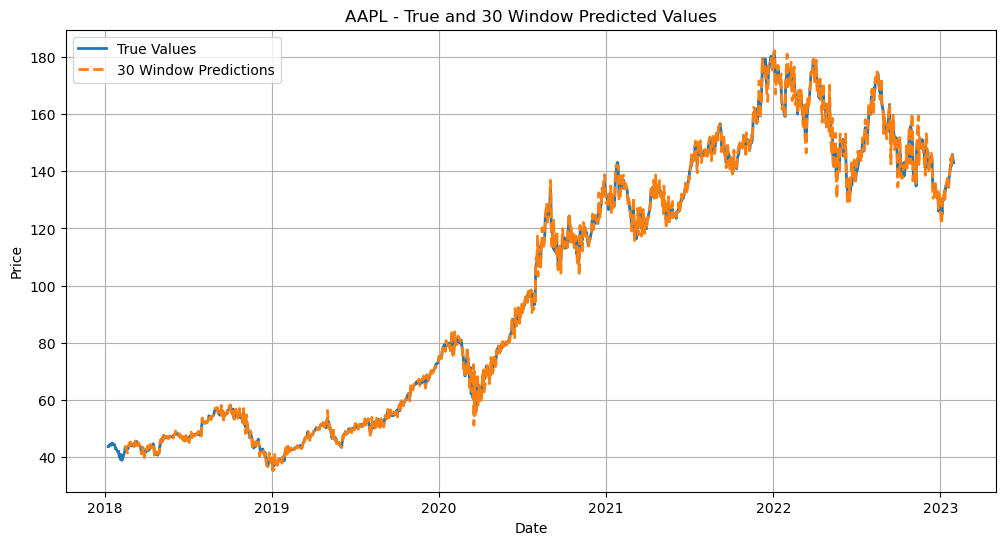

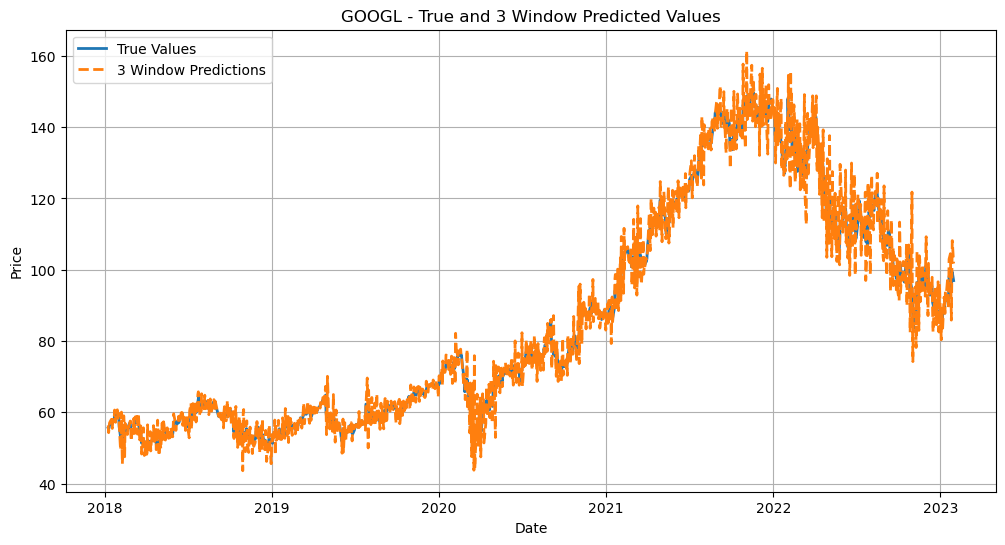

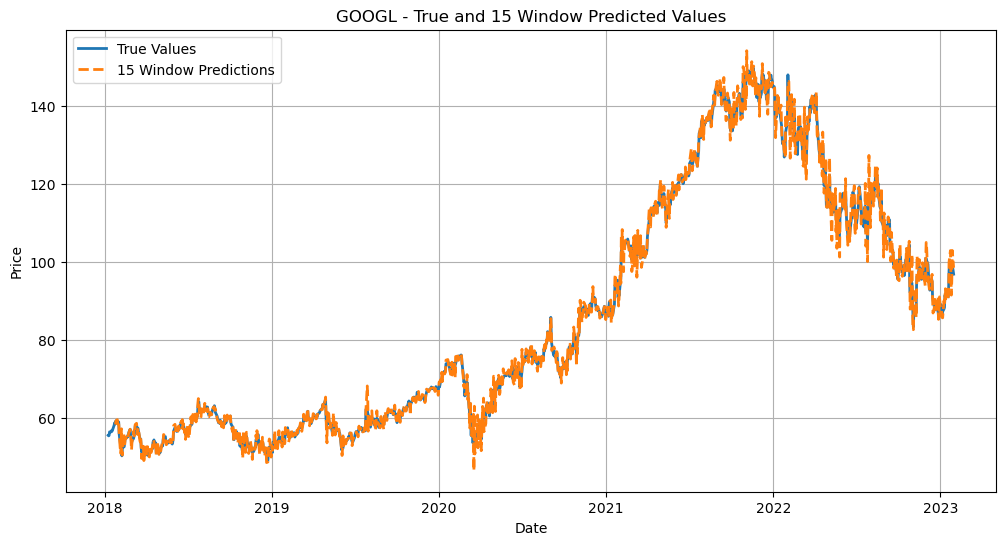

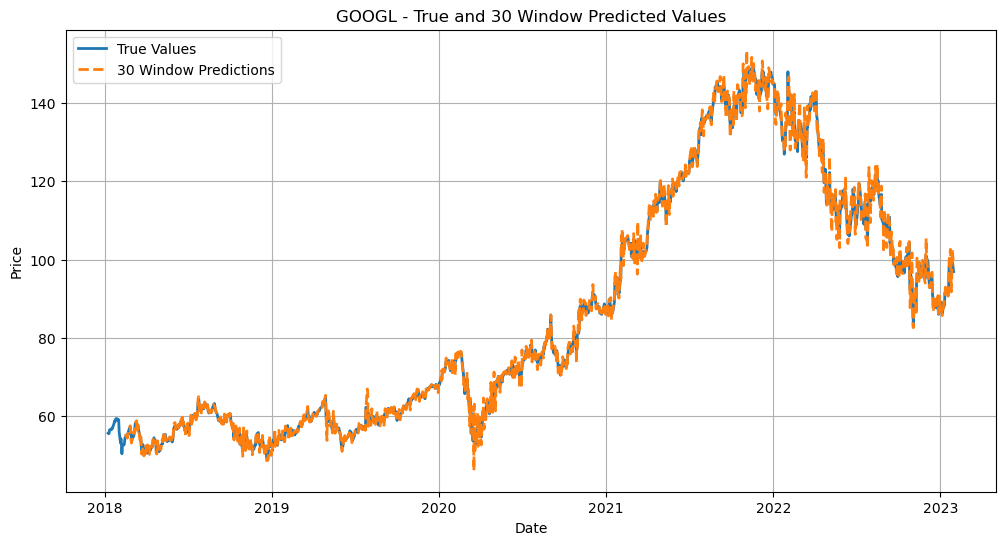

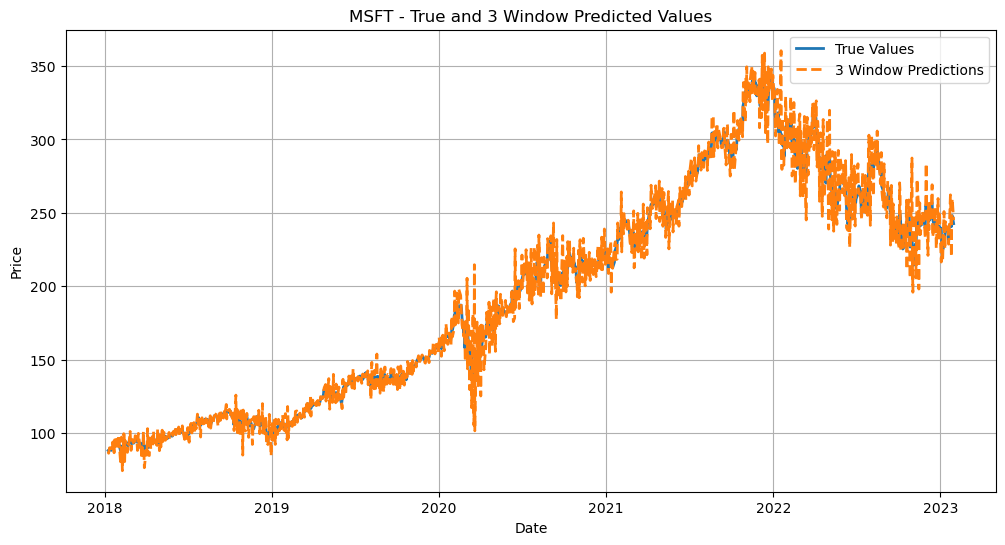

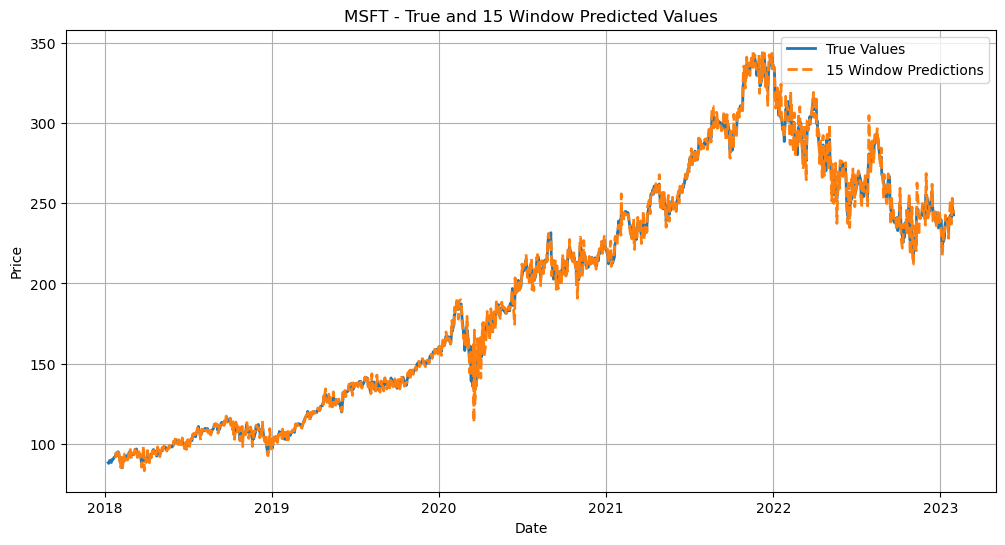

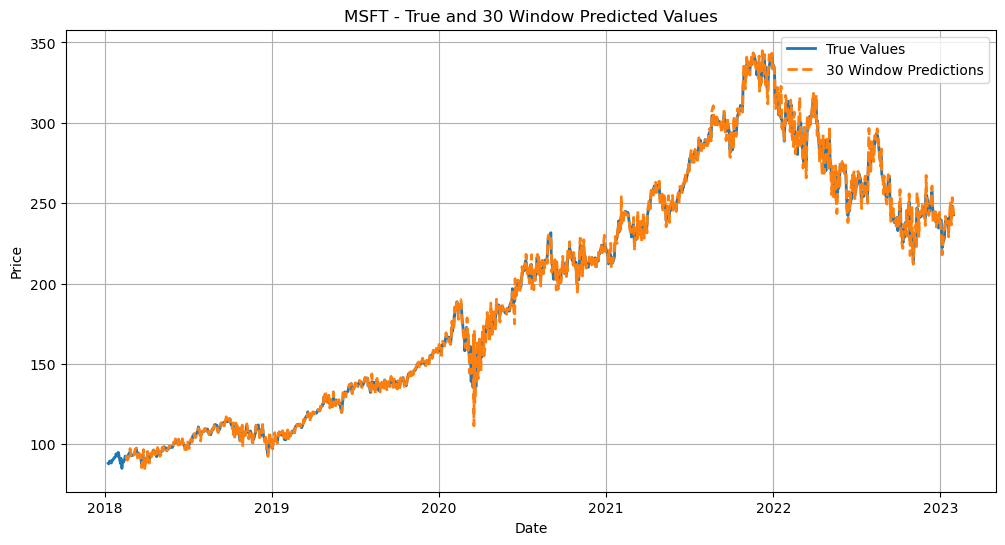

In [33]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Create a directory to save results and plots
base_dir = '../results'
now = datetime.now()
date_time_str = now.strftime('%Y%m%d_%H%M%S')
new_dir = os.path.join(base_dir, f"arima_experimental_{date_time_str}")

if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Save DataFrames to txt files
final_arima_predictions_df.to_csv(os.path.join(new_dir, 'final_arima_predictions.txt'), sep='\t', index=False)
metrics_df.to_csv(os.path.join(new_dir, 'metrics.txt'), sep='\t', index=False)

window_sizes = [3, 15, 30]
stocks = final_arima_predictions_df['Stock'].unique()

for stock in stocks:
    # Filter final_arima_predictions_df for each stock
    filtered_df = final_arima_predictions_df[final_arima_predictions_df['Stock'] == stock]
    
    # Extract date and original price
    dates = filtered_df['Date']
    y_true = filtered_df['Original Price']
    
    for window_size in window_sizes:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, y_true, label='True Values', linewidth=2)
        
        y_pred = filtered_df[window_size]
        plt.plot(dates, y_pred, label=f'{window_size} Window Predictions', linestyle='--', linewidth=2)
        
        # Customize the plot
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{stock} - True and {window_size} Window Predicted Values')
        plt.legend()
        plt.grid(True)
        
        # Save the plot for each window_size for a stock
        plt.savefig(os.path.join(new_dir, f'{stock}_{window_size}_window_plot.png'))
        plt.show()


In [34]:
import pandas as pd
import numpy as np

# Initialize a list to store ARIMA prediction dictionaries for different window sizes
arima_predictions_list_v2 = []

for stock in ['AAPL', 'GOOGL', 'MSFT']:
    stock_df_v2 = stock_data[stock]
    stock_df_v2.index = pd.to_datetime(stock_df_v2.index)

    for window_size in [3, 15, 30]:
        stock_window_df_v2 = results_df[(results_df['Stock'] == stock) & (results_df['Window Size'] == window_size)]
        
        for index, row in stock_window_df_v2.iterrows():
            date = row['Date'].to_timestamp()
            
            if date in stock_df_v2.index:
                original_price_v2 = stock_df_v2.loc[date]['Close']
                arima_prediction_v2 = row['ARIMA Prediction']
                arima_prediction_transformed_v2 = original_price_v2 * np.exp(arima_prediction_v2)
            else:
                original_price_v2 = np.nan
                arima_prediction_transformed_v2 = np.nan
            
            arima_predictions_list_v2.append({
                'Stock': stock,
                'Date': date,
                'Original Price': original_price_v2,
                'Window Size': window_size, 
                'ARIMA Prediction Transformed': arima_prediction_transformed_v2
            })

# Convert the list of dictionaries to DataFrame
final_arima_predictions_df_v2 = pd.DataFrame(arima_predictions_list_v2)

# Pivot the DataFrame to have a column for each window size
final_arima_predictions_df_v2 = final_arima_predictions_df_v2.pivot_table(index=['Stock', 'Date', 'Original Price'], 
                                                                    columns='Window Size', 
                                                                    values='ARIMA Prediction Transformed', 
                                                                    aggfunc='first').reset_index()

# Rename columns to include window size
final_arima_predictions_df_v2.columns = [
    f'{col[0]} Window {col[1]}' if isinstance(col, tuple) else col
    for col in final_arima_predictions_df_v2.columns
]

# Display the final DataFrame
final_arima_predictions_df_v2


Stock       Date  Original Price           3          15          30
0     AAPL 2018-01-09       43.582500   42.990609         NaN         NaN
1     AAPL 2018-01-10       43.572498   42.812766         NaN         NaN
2     AAPL 2018-01-11       43.820000   44.604636         NaN         NaN
3     AAPL 2018-01-12       44.272499   44.404063         NaN         NaN
4     AAPL 2018-01-16       44.047501   44.222343         NaN         NaN
...    ...        ...             ...         ...         ...         ...
3814  MSFT 2023-01-24      242.039993  247.801498  246.210098  244.596359
3815  MSFT 2023-01-25      240.610001  220.189601  237.004174  236.469616
3816  MSFT 2023-01-26      248.000000  249.772683  245.318964  246.385709
3817  MSFT 2023-01-27      248.160004  259.648242  253.118541  253.464907
3818  MSFT 2023-01-30      242.710007  245.065207  243.725821  242.336057

[3819 rows x 6 columns]

In [37]:
# Check for duplicate rows in results_df
duplicates_results_df = results_df.duplicated(subset=['Stock', 'Date', 'Window Size'])
print(f"Number of duplicate rows in results_df: {duplicates_results_df.sum()}")


Number of duplicate rows in results_df: 0


In [41]:
print(final_arima_predictions_df_v2.columns)


Index(['Stock', 'Date', 'Original Price', 3, 15, 30], dtype='object')


In [44]:
# Initialize a list to store dictionaries of missing dates for different stock and window sizes
missing_dates_list = []

# Loop through each unique stock and window size combination in results_df
for stock in results_df['Stock'].unique():
    for window_size in results_df['Window Size'].unique():
        
        # Get the set of unique dates for the specific stock and window size in results_df
        results_df_dates = set(results_df[(results_df['Stock'] == stock) & (results_df['Window Size'] == window_size)]['Date'])
        
        # Get the set of unique dates for the specific stock in final_arima_predictions_df_v2
        final_df_dates = set(final_arima_predictions_df_v2[final_arima_predictions_df_v2['Stock'] == stock]['Date'])
        
        # Find the dates that are in results_df but not in final_arima_predictions_df_v2
        missing_dates = results_df_dates - final_df_dates
        
        # If there are any missing dates, append them to the list along with stock and window size
        if missing_dates:
            missing_dates_list.append({
                'Stock': stock,
                'Window Size': window_size,
                'Missing Dates': missing_dates
            })

# Display the missing dates information
if missing_dates_list:
    print("Missing dates found!")
    for item in missing_dates_list:
        print(f"Stock: {item['Stock']}, Window Size: {item['Window Size']}, Missing Dates: {len(item['Missing Dates'])}")
else:
    print("No missing dates found!")

# If you want to print some of the actual missing dates, you can modify the print statement accordingly.


Missing dates found!
Stock: AAPL, Window Size: 3, Missing Dates: 1320
Stock: AAPL, Window Size: 15, Missing Dates: 1308
Stock: AAPL, Window Size: 30, Missing Dates: 1293
Stock: GOOGL, Window Size: 3, Missing Dates: 1320
Stock: GOOGL, Window Size: 15, Missing Dates: 1308
Stock: GOOGL, Window Size: 30, Missing Dates: 1293
Stock: MSFT, Window Size: 3, Missing Dates: 1320
Stock: MSFT, Window Size: 15, Missing Dates: 1308
Stock: MSFT, Window Size: 30, Missing Dates: 1293


In [36]:
for stock in ['AAPL', 'GOOGL', 'MSFT']:
    for window_size in [3, 15, 30]:
        dates_in_results_df = set(results_df[(results_df['Stock'] == stock) & 
                                              (results_df['Window Size'] == window_size)]['Date'])
        dates_in_final_arima_predictions_df = set(final_arima_predictions_df_v2[
            final_arima_predictions_df_v2['Stock'] == stock]['Date'])
        missing_dates = dates_in_results_df - dates_in_final_arima_predictions_df
        if missing_dates:
            print(f'Number of missing dates for {stock} and window size {window_size}: {len(missing_dates)}')


Number of missing dates for AAPL and window size 3: 1320
Number of missing dates for AAPL and window size 15: 1308
Number of missing dates for AAPL and window size 30: 1293
Number of missing dates for GOOGL and window size 3: 1320
Number of missing dates for GOOGL and window size 15: 1308
Number of missing dates for GOOGL and window size 30: 1293
Number of missing dates for MSFT and window size 3: 1320
Number of missing dates for MSFT and window size 15: 1308
Number of missing dates for MSFT and window size 30: 1293


In [29]:
import os
from datetime import datetime

base_dir = '../results'
now = datetime.now()
date_time_str = now.strftime('%Y%m%d_%H%M%S')
new_dir = os.path.join(base_dir, f"arima_experimental_{date_time_str}")

if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Save final_arima_predictions_df to txt file
predictions_filename = os.path.join(new_dir, 'final_arima_predictions.txt')
with open(predictions_filename, 'w') as file:
    file.write(final_arima_predictions_df.to_string(index=False))

# Save metrics_df to txt file
metrics_filename = os.path.join(new_dir, 'metrics.txt')
with open(metrics_filename, 'w') as file:
    file.write(metrics_df.to_string(index=False))
